# Local Model Training

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from model import get_dataloaders

import matplotlib.pyplot as plt

from model import FederatedCNN


100%|██████████| 20/20 [00:37<00:00,  1.88s/it]


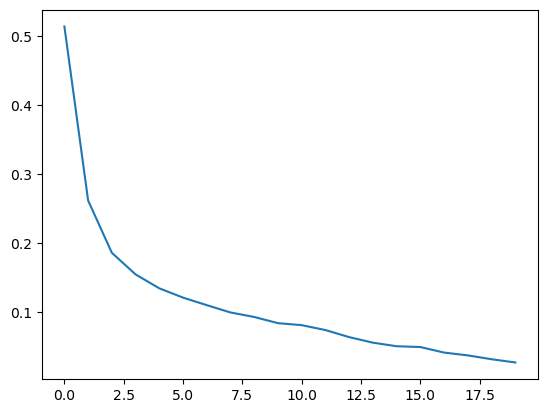

In [2]:
SRC_PATH = "./resources/pneumoniamnist.npz"


model = FederatedCNN(in_channels=1, num_classes=1)

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.7)
ce_loss = nn.BCEWithLogitsLoss()

train_dl, test_dl = get_dataloaders(SRC_PATH)

train_metrics, test_metrics = model.train_model(
    epochs=20,
    optimizer=optimizer,
    criterion=ce_loss,
    train_loader=train_dl,
    test_loader=test_dl
)

plt.plot(train_metrics["loss"])


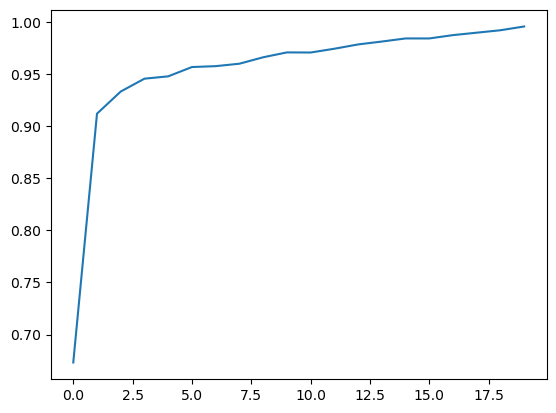

In [3]:
plt.plot(train_metrics["acc"])

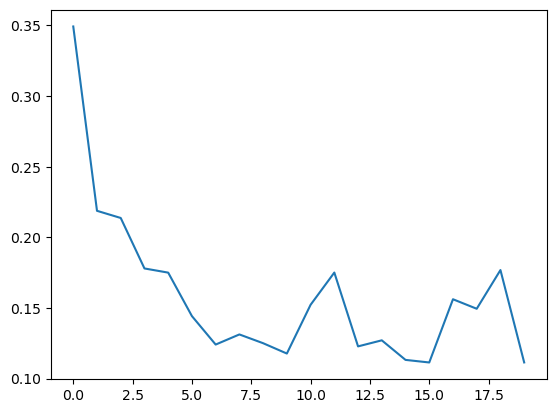

In [4]:
plt.plot(test_metrics["loss"])

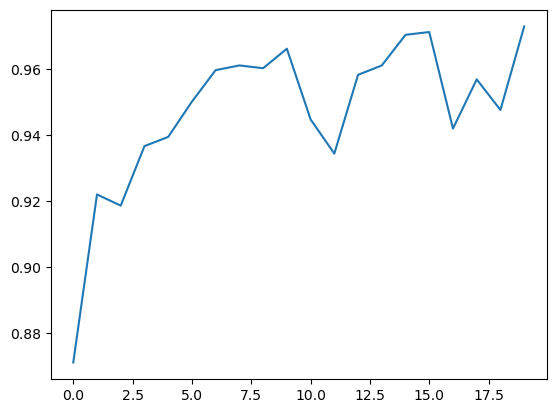

In [5]:
plt.plot(test_metrics["acc"])

# Federated Model Training

## Split Data for Federated Learning

In [6]:
import numpy as np
from model.dataset import read_medmnist

SRC_PATH = "./resources/pneumoniamnist.npz"
CLIENTS = 4  # Number of federated clients

data, labels = read_medmnist(SRC_PATH)
print(f"Shape of data: {data.shape} and shape of labels: {labels.shape}")


Shape of data: (5856, 28, 28) and shape of labels: (5856, 1)


In [7]:
l_data, l_labels = np.split(data, CLIENTS), np.split(labels, CLIENTS)
for client in range(CLIENTS):
    np.savez(f"./resources/pneumoniamnist_client{client}.npz", images=l_data[client], labels=l_labels[client])
    print("saved client data for client", client)

saved client data for client 0
saved client data for client 1
saved client data for client 2
saved client data for client 3


In [8]:
data, labels = read_medmnist("./resources/pneumoniamnist_client0.npz")
print(f"Shape of data: {data.shape} and shape of labels: {labels.shape}")

Shape of data: (1464, 28, 28) and shape of labels: (1464, 1)


## One-shot Federated Learning

In [9]:
def train_client(client, epochs=20, lr=0.001, momentum=0.7):
    model = FederatedCNN(in_channels=1, num_classes=1)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    ce_loss = nn.BCEWithLogitsLoss()

    train_dl, test_dl = get_dataloaders(f"./resources/pneumoniamnist_client{client}.npz")

    train_metrics, test_metrics = model.train_model(
        epochs=epochs,
        optimizer=optimizer,
        criterion=ce_loss,
        train_loader=train_dl,
        test_loader=test_dl
    )

    return model, train_metrics, test_metrics


# train for each client and get the models
models = []
for client in range(CLIENTS):
    model, _, _ = train_client(client)
    models.append(model)

100%|██████████| 50/50 [00:21<00:00,  2.32it/s]


In [10]:
def get_avg_params(models):
    """
    Get the average parameters of the models

    :param models: List of models to get parameters from
    :return: List of average parameters
    """
    # Get the parameters of the models
    params = [model.get_parameters() for model in models]
    # Align the parameters and average them
    params_avg = [sum(p) / len(p) for p in zip(*params)]
    return params_avg

def set_model_params(model, params):
    """
    Set the parameters of the model to the average of the parameters
    :param model: Model to set parameters for
    :param params: Parameters to set
    :return: None
    """
    params = map(lambda p: torch.from_numpy(p), params)
    with torch.no_grad():
        for model_params, p in zip(model.parameters(), params):
            model_params.data.copy_(p)


100%|██████████| 20/20 [00:04<00:00,  4.89it/s]


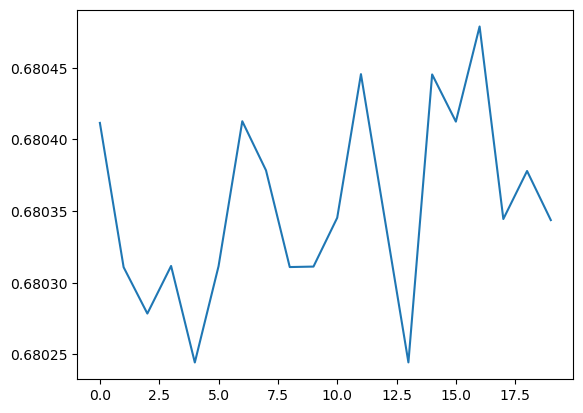

In [11]:
# average the parameters of the models
avg_params = get_avg_params(models)

# set the parameters of the global model to the average
global_model = FederatedCNN(in_channels=1, num_classes=1)
set_model_params(global_model, avg_params)

# test the global model on the complete data set
SRC_PATH = "./resources/pneumoniamnist.npz"

optimizer = optim.SGD(global_model.parameters(), lr=0.001, momentum=0.7)
ce_loss = nn.BCEWithLogitsLoss()
train_dl, test_dl = get_dataloaders(SRC_PATH)

train_metrics, test_metrics = global_model.train_model(
    epochs=20,
    optimizer=optimizer,
    criterion=ce_loss,
    train_loader=train_dl,
    test_loader=test_dl,
    mode="eval",
)

plt.plot(test_metrics["loss"])


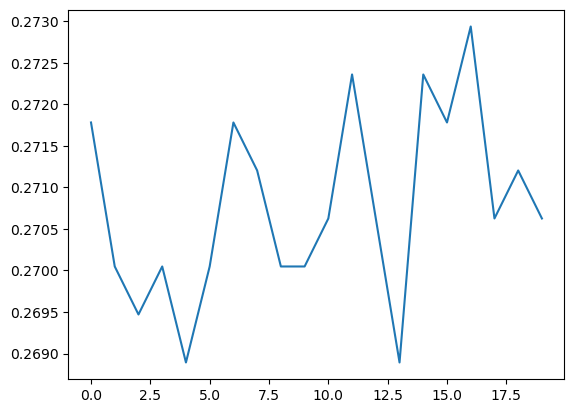

In [12]:
plt.plot(test_metrics["acc"])

## Federated Learning with Client Updates each Epoch

In [27]:
from tqdm import tqdm

# models and dataloaders for all clients
models = [FederatedCNN(in_channels=1, num_classes=1)] * CLIENTS
dataloaders = [get_dataloaders(f"./resources/pneumoniamnist_client{client}.npz") for client in range(CLIENTS)]

# parameters for training
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.7)
ce_loss = nn.BCEWithLogitsLoss()
EPOCHS = 50

# train each client iteratively, average parameters each epoch
avg_params = get_avg_params(models)
for i in tqdm(range(EPOCHS)):
    for client in range(CLIENTS):
        set_model_params(models[client], avg_params)
        train_dl, _ = dataloaders[client]
        model.train_epoch("train", train_dl, optimizer, ce_loss)
        avg_params = get_avg_params(models)

100%|██████████| 50/50 [01:19<00:00,  1.58s/it]


100%|██████████| 20/20 [00:01<00:00, 17.67it/s]


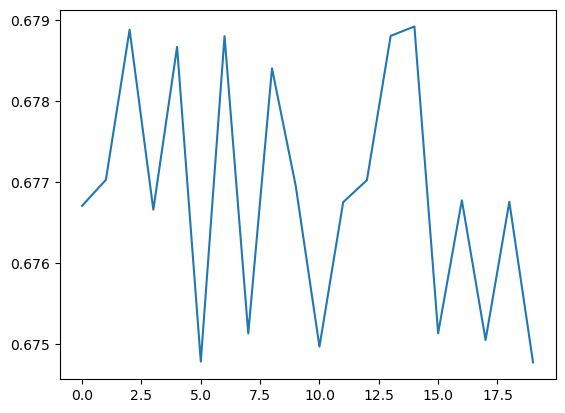

In [28]:
# test on global model
global_model = FederatedCNN(in_channels=1, num_classes=1)
set_model_params(global_model, avg_params)
_, test_metrics = global_model.train_model(
    epochs=20,
    optimizer=optimizer,
    criterion=ce_loss,
    train_loader=train_dl,
    test_loader=test_dl,
    mode="eval",
)
plt.plot(test_metrics["loss"])

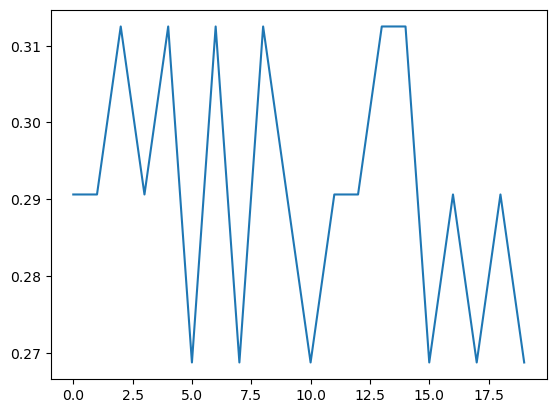

In [29]:
plt.plot(test_metrics["acc"])

## Test federated model

In [ ]:
# load model from pt
model